# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.09000000171363354
Score (max over agents) from episode 2: 0.10000000149011612
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import matplotlib.pyplot as plt
import torch
import time
import random
from collections import deque
from maddpg_agent import Agent

%matplotlib inline

In [7]:
# MADDPG function
def train_maddpg(n_episodes=2500, max_t=1000, consec_episodes=100, target_score=0.5, print_every=20, add_noise=True):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)"""
    
    n_agents = 2 # number of agents
    states_len = 24 # number of states
    agents_states = n_agents * states_len # combine states for both agents
    
    scores_window = deque(maxlen=100) # scores from recent episodes
    scores_all = [] # list of scores from episodes
    scores_moving_avgs = []  # list of scores moving averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = np.reshape(env_info.vector_observations, (1, agents_states)) # get current state for each agent and combine them
        agent_0.reset() # reset agent_0 environment
        agent_1.reset() # reset agent_0 environment
        scores = np.zeros(num_agents)  # initialize score for both agents
        
        eps_start_time = time.time() # start time to train each episode
        while True:
            action_0 = agent_0.act(states, add_noise) # select an action_0
            action_1 = agent_1.act(states, add_noise) # select an action_1           
            actions = np.concatenate((action_0, action_1), axis=0).flatten() # combine actions for both agents
            env_info = env.step(actions)[brain_name] # send actions for both agents to the environment
            next_states = np.reshape(env_info.vector_observations, (1, agents_states)) # combine the agent next states
            rewards = env_info.rewards # get reward
            done = env_info.local_done # see if episode finished
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # update and train agent_0
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # update and train agent_1
            scores += np.max(rewards) # update the scores for each agent
            states = next_states # roll over states to next time step
            if np.any(done): # exit loop at end of episode
                break

        time_per_eps = (time.time() - eps_start_time)/60.0 # end after training each episode
        max_score = np.max(scores)  # max scores for each episode
        scores_window.append(max_score) # save max scores for the episode to list
        scores_all.append(max_score) # save max scores to window
        scores_moving_avgs.append(np.mean(scores_window)) # save max scores moving average to list

        # print and save training results
        if i_episode % print_every == 0:
            print('\rEpisodes {}\tScore: {:.3f}\tAverage Score: {:.3f}\tMax Reward: {:.3f}\tTime per episode: {:.2f}mins'.format(i_episode, scores_all[-1], scores_moving_avgs[-1], np.max(scores_all[-20:]), time_per_eps))
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            
        # determine if environment is solved and save training results of models
        if scores_moving_avgs[-1] >= target_score and i_episode >= consec_episodes:
            print('\nEnvironment solved in {} episodes! \tAverage Score: {:.3f}.'.format(i_episode, scores_moving_avgs[-1]))
            # save weights
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            break
            
    return scores_all, scores_moving_avgs

In [10]:
# initialize and train the Agents
agent_0 = Agent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = Agent(state_size, action_size, num_agents=1, random_seed=0)
start_time = time.time() # Time Agents started training
scores, avgs_scores = train_maddpg()
elapsed_time = (time.time() - start_time) / 60.0 # Duration of time it took the Agents to train
print("Total time it took to train agents: {0:3.2f}mins.".format(elapsed_time))

Episodes 20	Score: 0.000	Average Score: 0.000	Max Reward: 0.000	Time per episode: 0.08mins
Episodes 40	Score: 0.000	Average Score: 0.003	Max Reward: 0.100	Time per episode: 0.09mins
Episodes 60	Score: 0.000	Average Score: 0.003	Max Reward: 0.100	Time per episode: 0.09mins
Episodes 80	Score: 0.000	Average Score: 0.003	Max Reward: 0.000	Time per episode: 0.09mins
Episodes 100	Score: 0.000	Average Score: 0.003	Max Reward: 0.100	Time per episode: 0.09mins
Episodes 120	Score: 0.100	Average Score: 0.011	Max Reward: 0.100	Time per episode: 0.19mins
Episodes 140	Score: 0.100	Average Score: 0.016	Max Reward: 0.200	Time per episode: 0.20mins
Episodes 160	Score: 0.000	Average Score: 0.022	Max Reward: 0.200	Time per episode: 0.09mins
Episodes 180	Score: 0.200	Average Score: 0.031	Max Reward: 0.200	Time per episode: 0.32mins
Episodes 200	Score: 0.100	Average Score: 0.039	Max Reward: 0.200	Time per episode: 0.19mins
Episodes 220	Score: 0.100	Average Score: 0.048	Max Reward: 0.600	Time per episode: 0

Episodes 1800	Score: 0.400	Average Score: 0.204	Max Reward: 0.700	Time per episode: 0.53mins
Episodes 1820	Score: 0.100	Average Score: 0.217	Max Reward: 0.600	Time per episode: 0.27mins
Episodes 1840	Score: 0.200	Average Score: 0.239	Max Reward: 0.800	Time per episode: 0.31mins
Episodes 1860	Score: 0.200	Average Score: 0.255	Max Reward: 0.600	Time per episode: 0.30mins
Episodes 1880	Score: 0.300	Average Score: 0.264	Max Reward: 0.700	Time per episode: 0.40mins
Episodes 1900	Score: 0.100	Average Score: 0.267	Max Reward: 0.500	Time per episode: 0.17mins
Episodes 1920	Score: 0.100	Average Score: 0.284	Max Reward: 0.800	Time per episode: 0.18mins
Episodes 1940	Score: 0.100	Average Score: 0.281	Max Reward: 1.000	Time per episode: 0.18mins
Episodes 1960	Score: 0.300	Average Score: 0.287	Max Reward: 0.700	Time per episode: 0.39mins
Episodes 1980	Score: 0.500	Average Score: 0.307	Max Reward: 0.900	Time per episode: 0.70mins
Episodes 2000	Score: 0.300	Average Score: 0.343	Max Reward: 1.100	Time

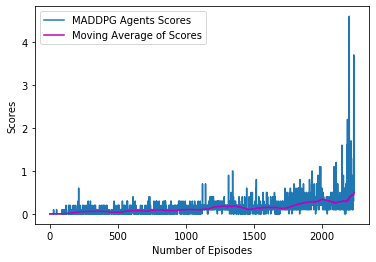

In [12]:
# Plot the scores of trained DDPG Agents
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG Agents Scores')
plt.plot(np.arange(len(scores)), avgs_scores, c='m', label='Moving Average of Scores')
plt.ylabel('Scores')
plt.xlabel('Number of Episodes')
plt.legend(loc='upper left')
plt.show()

When finished, you can close the environment.

In [13]:
env.close()